In [2]:
import os
import logging
from tqdm import tqdm

import jiant.utils.python.io as py_io
import jiant.utils.python.filesystem as filesystem

logging.basicConfig(
  format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", level=logging.INFO
)
logger = logging.getLogger(__name__)

def load_zlog(fol_path):
    all_paths = filesystem.find_files_with_ext(fol_path, "zlog")
    log_data = {}
    for path in all_paths:
        key = os.path.abspath(path).replace(os.path.abspath(fol_path), "")[1:].replace(".zlog", "")
        log_data[key] = py_io.read_jsonl(path)
    return log_data

def read_training_dynamics(
  task_name, model_name, phase_name, split_name="training",
  strip_last=False, id_field="guid", burn_out=None):
  """
  Given path to logged training dynamics, merge stats across epochs.
  Returns:
  - Dict between ID of a train instances and its gold label, and the list of logits across epochs.
  """
  train_dynamics = {}

  log_path = f"./runs/{task_name}/{model_name}/{phase_name}/"
  dynamic_zlogs = load_zlog(log_path)
  num_epochs = len(dynamic_zlogs)
  if burn_out:
    num_epochs = burn_out
  logger.info(f"Reading {num_epochs} dynamic logs for {task_name} ...")

  dynamic_log = dynamic_zlogs[f"{split_name}_dynamic"]
  for record in dynamic_log:
    guid = record[id_field] if not strip_last else record[id_field][:-1]
    if guid not in train_dynamics:
      train_dynamics[guid] = {"gold": record["gold"], "logits": []}
    train_dynamics[guid]["logits"].append(record["logits"])

  logger.info(f"Read training dynamics for {len(train_dynamics)} train instances.")
  return train_dynamics


In [44]:
import numpy as np
import torch

task = "cosmoqa"

main_train_dynamics = read_training_dynamics(
  task, "anli-mix-roberta",
  "1000-shot", split_name="val")
null_train_dynamics = read_training_dynamics(
  task, "anli-mix-roberta",
  "1000-shot-null", split_name="val")

v_entropy_y = 0
v_entropy_yx = 0


val_labels = torch.load(f"./cache/roberta-large/{task}/val_labels/data_00000.chunk")
#val_labels2 = torch.load(f"./cache/roberta-large/{task}/val_labels/data_00001.chunk")
#val_labels = np.concatenate((val_labels, val_labels2), axis=0)
N = len(val_labels)

val_labels = [[label] for label in val_labels]

prediction_main = [x['logits'][0] for x in main_train_dynamics.values()]
prediction_null = [x['logits'][0] for x in null_train_dynamics.values()]
val_batch_main = torch.Tensor(prediction_main)
val_batch_null = torch.Tensor(prediction_null)
label_batch = torch.Tensor(val_labels).type(torch.int64)


if len(val_batch_main.shape) == 3:
  prediction_batch_main = torch.softmax(val_batch_main, 2)
  prediction_batch_null = torch.softmax(val_batch_null, 2)
  label_batch = label_batch.view(*label_batch.shape, 1)
  prediction_batch_main = torch.gather(prediction_batch_main, 2, label_batch)
  prediction_batch_null = torch.gather(prediction_batch_null, 2, label_batch)
else:
  prediction_batch_main  = torch.softmax(val_batch_main, 1)
  prediction_batch_null  = torch.softmax(val_batch_null, 1)
  prediction_batch_main = torch.gather(prediction_batch_main, 1, label_batch)
  prediction_batch_null = torch.gather(prediction_batch_null, 1, label_batch)
  label_batch = label_batch.view(label_batch.shape[0])
  label_batch = label_batch.view(*label_batch.shape, 1)

pvi_main = torch.where(
  (label_batch!=0),
  torch.log2(prediction_batch_main),
  torch.zeros_like(prediction_batch_main)
)

pvi_null = torch.where(
  (label_batch!=0),
  torch.log2(prediction_batch_null),
  torch.zeros_like(prediction_batch_null)
)

pvi_tensor = -pvi_null + pvi_main
V_info = (1/N)*torch.sum(pvi_tensor)
pvi = [x.item() for x in pvi_tensor]

logger.info(f"Minimum PVI: {min(pvi)}")
logger.info(f"Maximum PVI: {max(pvi)}")

val_data = py_io.read_jsonl(f"/content/tasks/curriculum/{task}/val.jsonl")

pvi_record = []
for i, data in enumerate(val_data):
  record = data
  record['pvi'] = pvi[i]
  pvi_record.append(record)

py_io.write_jsonl(
    data=val_data,
    path=f"/content/tasks/curriculum/{task}/val_pvi.jsonl",
)

logger.info(f"Wrote {task} pvi record to file.")

2021-12-12 14:48:12,362 - INFO - __main__ - Reading 10 dynamic logs for cosmoqa ...
2021-12-12 14:48:12,366 - INFO - __main__ - Read training dynamics for 5452 train instances.
2021-12-12 14:48:12,432 - INFO - __main__ - Reading 6 dynamic logs for cosmoqa ...
2021-12-12 14:48:12,438 - INFO - __main__ - Read training dynamics for 5452 train instances.
2021-12-12 14:48:12,460 - INFO - __main__ - Minimum PVI: -9.902734756469727
2021-12-12 14:48:12,461 - INFO - __main__ - Maximum PVI: 1.0124467611312866
2021-12-12 14:48:12,524 - INFO - __main__ - Wrote cosmoqa pvi record to file.


In [45]:
from operator import itemgetter

num_bucket = 3
sorted_val_data = sorted(pvi_record, key=itemgetter('pvi'))
def split(a, n):
  k, m = divmod(len(a), n)
  return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

val_data_buckets = list(split(sorted_val_data, 3))

logger.info(f"Devided {task} validation data into difficulty partitions.")

2021-12-12 14:48:12,928 - INFO - __main__ - Devided cosmoqa validation data into difficulty partitions.


In [46]:
py_io.write_jsonl(
    data=val_data_buckets[0],
    path=f"/content/tasks/curriculum/{task}/val_simple.jsonl",
)

py_io.write_jsonl(
    data=val_data_buckets[0],
    path=f"/content/tasks/curriculum/{task}/val_medium.jsonl",
)

py_io.write_jsonl(
    data=val_data_buckets[0],
    path=f"/content/tasks/curriculum/{task}/val_hard.jsonl",
)

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch
import tqdm

from collections import defaultdict
from typing import List


def compute_correctness(trend: List[float]) -> float:
  """
  Aggregate #times an example is predicted correctly during all training epochs.
  """
  return sum(trend)


def compute_forgetfulness(correctness_trend: List[float]) -> int:
  """
  Given a epoch-wise trend of train predictions, compute frequency with which
  an example is forgotten, i.e. predicted incorrectly _after_ being predicted correctly.
  Based on: https://arxiv.org/abs/1812.05159
  """
  if not any(correctness_trend):  # Example is never predicted correctly, or learnt!
      return 1000
  learnt = False  # Predicted correctly in the current epoch.
  times_forgotten = 0
  for is_correct in correctness_trend:
    if (not learnt and not is_correct) or (learnt and is_correct):
      # nothing changed.
      continue
    elif learnt and not is_correct:
      # Forgot after learning at some point!
      learnt = False
      times_forgotten += 1
    elif not learnt and is_correct:
      # Learnt!
      learnt = True
  return times_forgotten

def compute_train_dy_metrics(training_dynamics):
  """
  Given the training dynamics (logits for each training instance across epochs), compute metrics
  based on it, for data map coorodinates.
  Computed metrics are: confidence, variability, correctness, forgetfulness, threshold_closeness---
  the last two being baselines from prior work
  (Example Forgetting: https://arxiv.org/abs/1812.05159 and
    Active Bias: https://arxiv.org/abs/1704.07433 respectively).
  Returns:
  - DataFrame with these metrics.
  - DataFrame with more typical training evaluation metrics, such as accuracy / loss.
  """
  confidence_ = {}
  variability_ = {}
  threshold_closeness_ = {}
  correctness_ = {}
  forgetfulness_ = {}

  # Functions to be applied to the data.
  variability_func = lambda conf: np.std(conf)
  #variability_func = lambda conf: np.sqrt(np.var(conf) + np.var(conf) * np.var(conf) / (len(conf)-1))
  threshold_closeness_func = lambda conf: conf * (1 - conf)

  loss = torch.nn.CrossEntropyLoss()

  num_tot_epochs = len(list(training_dynamics.values())[0]["logits"])
  logger.info(f"Computing training dynamics across {num_tot_epochs} epochs")
  logger.info("Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness")

  logits = {i: [] for i in range(num_tot_epochs)}
  targets = {i: [] for i in range(num_tot_epochs)}
  training_accuracy = defaultdict(float)

  for guid in tqdm.tqdm(training_dynamics):
    correctness_trend = []
    true_probs_trend = []

    record = training_dynamics[guid]
    for i, epoch_logits in enumerate(record["logits"]):
      probs = torch.nn.functional.softmax(torch.Tensor(epoch_logits), dim=-1)
      true_class_prob = float(probs[record["gold"]])
      true_probs_trend.append(true_class_prob)

      prediction = np.argmax(epoch_logits)
      is_correct = (prediction == record["gold"]).item()
      correctness_trend.append(is_correct)

      training_accuracy[i] += is_correct
      logits[i].append(epoch_logits)
      targets[i].append(record["gold"])

    correctness_[guid] = compute_correctness(correctness_trend)
    confidence_[guid] = np.mean(true_probs_trend)
    variability_[guid] = variability_func(true_probs_trend)

    forgetfulness_[guid] = compute_forgetfulness(correctness_trend)
    threshold_closeness_[guid] = threshold_closeness_func(confidence_[guid])

  # Should not affect ranking, so ignoring.
  epsilon_var = np.mean(list(variability_.values()))

  column_names = ['guid',
                  'index',
                  'threshold_closeness',
                  'confidence',
                  'variability',
                  'correctness',
                  'forgetfulness',]
  df = pd.DataFrame([[guid,
                      i,
                      threshold_closeness_[guid],
                      confidence_[guid],
                      variability_[guid],
                      correctness_[guid],
                      forgetfulness_[guid],
                      ] for i, guid in enumerate(correctness_)], columns=column_names)

  df_train = pd.DataFrame([[i,
                            loss(torch.Tensor(logits[i]), torch.LongTensor(targets[i])).item() / len(training_dynamics),
                            training_accuracy[i] / len(training_dynamics)
                            ] for i in range(num_tot_epochs)],
                          columns=['epoch', 'loss', 'train_acc'])
  return df, df_train

In [48]:
task = "logiqa"

train_dynamics = read_training_dynamics(task, "anli-mix-roberta", "1000-shot", split_name="training")
total_epochs = len(list(train_dynamics.values())[0]["logits"])
train_dy_metrics, _ = compute_train_dy_metrics(train_dynamics)

2021-12-12 14:48:23,131 - INFO - __main__ - Reading 10 dynamic logs for logiqa ...
2021-12-12 14:48:23,135 - INFO - __main__ - Read training dynamics for 2000 train instances.
2021-12-12 14:48:23,138 - INFO - __main__ - Computing training dynamics across 5 epochs
2021-12-12 14:48:23,138 - INFO - __main__ - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 2000/2000 [00:00<00:00, 10152.26it/s]


In [49]:

def plot_data_map(
    dataframe: pd.DataFrame,
    hue_metric: str = 'correct.',
    title: str = 'Monotonicity',
    model: str = 'RoBERTa',
    show_hist: bool = False,
    max_instances_to_plot = 55000):
    # Set style.
    sns.set(style='whitegrid', font_scale=1.6, font='Georgia', context='paper')
    logger.info(f"Plotting figure for {title} using the {model} model ...")

    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
    else:
        fig = plt.figure(figsize=(12, 8), )
        gs = fig.add_gridspec(3, 2, width_ratios=[5, 1])
        ax0 = fig.add_subplot(gs[:, 0])

    # Make the scatterplot.
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(
        x=main_metric,
        y=other_metric,
        ax=ax0,
        data=dataframe,
        hue=hue,
        palette=pal,
        style=style,
        s=30
    )

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    func_annotate = lambda  text, xyc, bbc : ax0.annotate(
        text,
        xy=xyc,
        xycoords="axes fraction",
        fontsize=15,
        color='black',
        va="center",
        ha="center",
        rotation=350,
        bbox=bb(bbc)
    )
    an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
    an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
    an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')

    if show_hist:
        plot.set_title(f"{title}-{model} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[0, 1])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[2, 1])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')
        plott1[0].set_ylabel('density')

        plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('density')

    fig.tight_layout()
    fig.savefig(f'./runs/{task}/anli-mix-roberta/1000-shot/data_map.pdf')

2021-12-12 14:48:29,113 - INFO - __main__ - Plotting figure for Monotonicity using the RoBERTa model ...


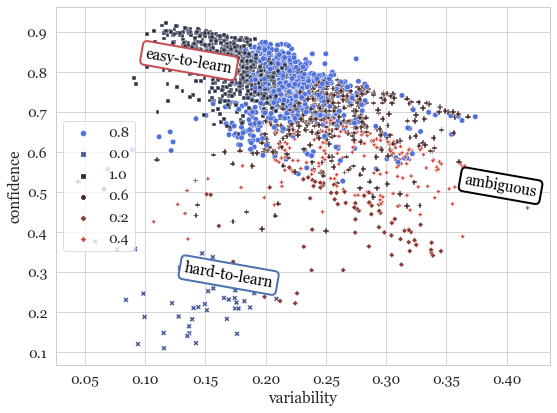

In [50]:
plot_data_map(train_dy_metrics)